In [1]:
#Implement "Adaptive Enhancement for non-uniform illumination Images via Pixel-wise Histogram Modification and Color Reconstruction"


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Pixel-wise Demarcation Sec
def Demarcation(gray_img):
    
    #find gary image average luminance
    avg_lum = gray_img.mean() / 255
    
    #print('avg luminanc:', avg_lum)
    
    #Bilateral filter
    bila_img = cv2.bilateralFilter(gray_img, 7, 13, 13) / 255
    
    #Calculate Y_a
    Y_a = 0.5 + np.power((avg_lum - bila_img), 3)
    
    #print(np.max(Y_a))
    #print(np.min(Y_a))
    
    return Y_a, avg_lum
    

In [4]:
def modify_histogram(gray_img, Y_a, avg_lum):
    
    #calculate gray image histogram
    hist = cv2.calcHist([gray_img], [0], None, [256], [0, 256])
    hist = hist / (gray_img.shape[0] * gray_img.shape[1])
    #print('hist:', hist[:,0].shape)
    
    #calculate w
    w = np.zeros(256)
    
    for i in range(0, 256):
        w[i] = abs(i - 127) / 255 +0.7
    
    #print('sum of w:', sum(w))
    p_w = hist[:,0] * w
    
    #calculate P_l
    
    P_l = sum(p_w[0: int(avg_lum * 255) + 1])
    
    #calculate P_h
    
    P_h = sum(p_w[int(avg_lum * 255) + 1: 256])

    #print('pl:',P_l)
    #print('ph:',P_h)
    #print('sum of p*w:', sum(p_w))

    #calculate Nonlinear Modification to Histogram
    
    mod_img = np.zeros(gray_img.shape, np.float32)
    
    #list_a = []
    #list_b = []
    
    #calculate all pixel
    for i in range(0, gray_img.shape[0]):
        for j in range(0, gray_img.shape[1]):
            if gray_img[i, j] < avg_lum * 255 :
                sum_p_w = sum(p_w[0 : gray_img[i, j] + 1])
                mod_img[i, j] = Y_a[i, j] * sum_p_w / P_l
                #list_a.append(Y_a[i, j] * sum_p_w / P_l)
            else:
                sum_p_w = sum(p_w[int(avg_lum * 255) : gray_img[i, j] + 1])
                mod_img[i, j] = Y_a[i, j] + (1 - Y_a[i, j]) * sum_p_w / P_h
                #list_b.append(Y_a[i, j] + (1 - Y_a[i, j]) * sum_p_w / P_h)
    
    mod_img = (mod_img - np.min(mod_img)) / (np.max(mod_img) - np.min(mod_img))
    
    mod_img = (mod_img * 255).astype(np.uint8)
        
    #hist = cv2.calcHist([mod_img], [0], None, [256], [0, 256])
    
    #plt.bar(range(1,257), hist)
    #plt.show()
    
    return mod_img

In [5]:
def color_reconstruction(ori_img, gray_img, mod_img):
    
    ori_img = ori_img.astype(np.float32)
    gray_img = gray_img.astype(np.float32)
    mod_img = mod_img.astype(np.float32)
    
    de_gray_img = np.zeros(gray_img.shape, np.float32)
    
    for i in range(gray_img.shape[0]):
        for j in range(gray_img.shape[1]):
            if gray_img[i,j] != 0:
                de_gray_img[i,j] = 1/gray_img[i,j]
    
    E_s_c = np.zeros(ori_img.shape, np.float32)
    E_p_c = np.zeros(ori_img.shape, np.float32)
    E_c = np.zeros(ori_img.shape, np.float32)
    avg_lum = gray_img.mean()
    max_g = np.max(gray_img)
    min_g = np.min(gray_img)
    
    for i in range(ori_img.shape[2]):
        E_p_c[:,:,i] = ori_img[:,:,i] * mod_img * de_gray_img
        E_s_c[:,:,i] = 0.5 * ((ori_img[:,:,i] * mod_img * de_gray_img) + ori_img[:,:,i] + mod_img - gray_img)
        E_c[:,:,i] = E_s_c[:,:,i] + (ori_img[:,:,i] - gray_img)*(avg_lum/(max_g - min_g))

    E_c[E_c > 255] = 255
    E_c[E_c < 0] = 0
    #print('max:', np.max(E_c))
    #print('min:', np.min(E_c))
    
    E_c = E_c.astype(np.uint8)
    
    #cv2.imshow('E_c', E_c)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    return E_c

In [6]:
def local_contrast(colo_img):
    bila_img = cv2.bilateralFilter(colo_img, 7, 13, 13) / 255
    colo_img = colo_img / 255
    
    for i in range(colo_img.shape[0]):
        for j in range(colo_img.shape[1]):
            for k in range(colo_img.shape[2]):
                if colo_img[i, j, k] != 0:
                    if colo_img[i, j, k] <= bila_img[i, j, k]:
                        bila_img[i, j, k] = np.power(colo_img[i, j, k], (bila_img[i, j, k] / colo_img[i, j, k]))
                if colo_img[i, j, k] != 1:
                    if colo_img[i, j, k] > bila_img[i, j, k]:
                        bila_img[i, j, k] = 1 - np.power((1 - colo_img[i, j, k]), ((1 - bila_img[i, j, k]) / (1 - colo_img[i, j, k])))
    bila_img = bila_img * 255
    bila_img = bila_img.astype(np.uint8)
    
    #cv2.imshow('loc con', bila_img)
    #cv2.waitKey(0)
    return bila_img

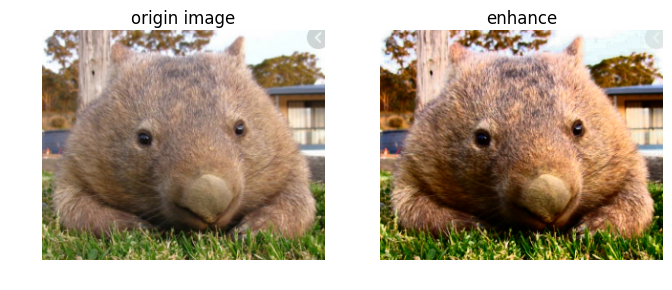

True

In [7]:
#main
img = cv2.imread('./unknown.png')
#img = cv2.imread('./images/light/test_A_3.jpg')
img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_Y_a, img_avg_lum = Demarcation(img_g)
mod_img = modify_histogram(img_g, img_Y_a, img_avg_lum)

recon_img = color_reconstruction(img, img_g, mod_img)
loc_con_img = local_contrast(recon_img)

#cv2.imshow('ori img', img)
#cv2.imshow('recon img', recon_img)
#cv2.imshow('loc con img', loc_con_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.figure(num='color enhance', figsize=(8,8))

plt.subplot(1,2,1)
plt.title('origin image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,2,2)
plt.title('enhance')
plt.imshow(cv2.cvtColor(loc_con_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


cv2.imwrite('./result.png', loc_con_img)